In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from realism.realism_utils import make_orderbook_for_analysis, MID_PRICE_CUTOFF
from util.plotting import liquidity_telemetry as lt

In [3]:
def get_delays_and_profits(paths):
    output = None
    slave_ids = {}
    master_ids = {}
    for path in paths:
        master_profit = None
        delays = {}
        slave_ids[path] = []
        for file in os.listdir(path):
            if 'HerdMasterAgent' in file:
                try:
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    master_profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                    m_id = int(file.split('HerdMasterAgent')[1].split('.')[0])
                    master_ids[path] = m_id
                except (IndexError, KeyError):
                    continue                
            if 'HerdSlaveAgent' in file:
                try:
                    s_id = int(file.split('HerdSlaveAgent')[1].split('.')[0])
                    slave_ids[path].append(s_id)
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    delay = df.loc[df.EventType == 'DELAY', 'Event'].values[0]
                    profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                    delays[delay] = profit
                except (IndexError, KeyError):
                    continue
        x, y = np.asarray(sorted(delays.items()))[:, 0], np.asarray(sorted(delays.items()))[:, 1]
        temp = pd.DataFrame({'DELAY': x, 'SLAVE_PROFIT': y})
        temp['MASTER_PROFIT'] = master_profit
        temp['SIMULATION'] = path
        if output is None:
            output = temp
        else:
            output = output.append(temp)
    output['PERCENT'] = output.SLAVE_PROFIT/output.MASTER_PROFIT
    output = output.sort_values(by='DELAY').reset_index(drop=True)
    return output, slave_ids, master_ids

In [4]:
def get_herd_impact(paths, slaves):
    output = None
    for path in paths:
        df = pd.read_pickle(os.path.join(path,'EXCHANGE_AGENT.bz2'), compression='bz2')
        df = df[df.EventType == 'ORDER_ACCEPTED']
        df.reset_index(inplace=True)
        temp = pd.DataFrame.from_dict(df[['EventTime', 'Event']].Event.to_dict()).T
        temp['EventTime'] = df.EventTime
        t = temp[temp.agent_id.isin(slaves[path])][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
        t.rename(columns={'quantity': 'slave_vol'}, inplace=True)
        t1 = temp[temp.is_buy_order == True][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
        t1.rename(columns={"quantity": 'tot_vol'}, inplace=True)
        t['SIMULATION'] = path
        t['tot_vol'] = t1.tot_vol
        
        output = t if output is None else output.append(t)
    return output

Configuration 1

In [5]:
# HERD 01 old

PATHS = ["log/prova06/herd06_seed_4153361530"]

df, slave_ids, master_id = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,7039340,21,25,log/prova06/herd06_seed_4153361530,0.84
1,79073318,38,25,log/prova06/herd06_seed_4153361530,1.52
2,134149043,38,25,log/prova06/herd06_seed_4153361530,1.52
3,140291801,38,25,log/prova06/herd06_seed_4153361530,1.52
4,142094781,38,25,log/prova06/herd06_seed_4153361530,1.52
5,175359692,38,25,log/prova06/herd06_seed_4153361530,1.52
6,183692435,38,25,log/prova06/herd06_seed_4153361530,1.52
7,213131929,38,25,log/prova06/herd06_seed_4153361530,1.52
8,215560249,38,25,log/prova06/herd06_seed_4153361530,1.52
9,216529671,38,25,log/prova06/herd06_seed_4153361530,1.52


In [7]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY                 SLAVE_PROFIT                MASTER_PROFIT  \
           mean           std           mean           std           mean   
g                                                                           
0  5.451039e+06  3.391201e+06  121466.566667  57698.744666  361788.566667   
1  2.011549e+07  5.326870e+06   81153.900000  72623.971065  372454.900000   
2  3.380075e+07  3.182857e+06   39698.833333  49934.195325  368777.700000   
3  4.504049e+07  4.113942e+06   40577.200000  34832.886657  374281.733333   
4  5.614587e+07  4.048804e+06   41396.433333  36005.700262  364933.633333   
5  6.858103e+07  4.457184e+06   34893.200000  30088.166931  373613.100000   
6  8.024152e+07  2.874059e+06   22624.900000  25490.133946  381073.000000   
7  9.225896e+07  4.061049e+06   24295.066667  24807.447112  366336.033333   

                  PERCENT            
            std      mean       std  
g                                    
0  33159.791368  0.335302  0.159015  
1  38049.902468  0.223475  0.212059  
2  39698.989359  0.105323  0.139609  
3  40390.554771  0.107873  0.097397  
4  36776.624928  0.112582  0.101762  
5  41828.035033  0.095524  0.089341  
6  40303.475642  0.059463  0.069428  
7  35891.557875  0.067591  0.071238

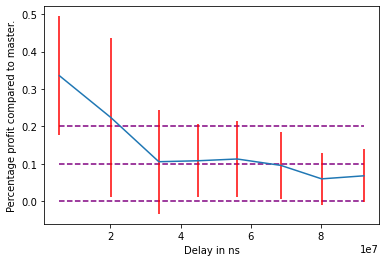

In [8]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.1, 0.2], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [9]:
t = get_herd_impact(PATHS, slave_ids)

In [10]:
t['PERCENT'] = t.slave_vol/t.tot_vol*100

In [11]:
#t.reset_index(inplace=True)
temp = t.sort_values(by='EventTime').groupby('EventTime').agg(['mean', 'std']).reset_index()
temp

EventTime      slave_vol                      tot_vol  \
                                 mean            std          mean   
0  2020-06-03 09:30:00   65056.500000   18622.616237  3.075332e+06   
1  2020-06-03 09:35:00   68173.000000   11706.875877  3.087636e+06   
2  2020-06-03 09:40:00   55333.333333   10528.497759  3.076544e+06   
3  2020-06-03 09:45:00   97021.500000   47698.017866  3.110875e+06   
4  2020-06-03 09:50:00   91094.166667   60949.057077  3.117700e+06   
5  2020-06-03 09:55:00   97487.666667   54341.422781  3.093468e+06   
6  2020-06-03 10:00:00   96321.333333   44364.463435  3.102780e+06   
7  2020-06-03 10:05:00  143523.666667  121717.477362  3.096773e+06   
8  2020-06-03 10:10:00  114680.833333  104704.970055  3.094282e+06   
9  2020-06-03 10:15:00   66892.833333   10474.360704  3.093510e+06   
10 2020-06-03 10:20:00  127438.166667  154727.529941  3.087380e+06   
11 2020-06-03 10:25:00  135810.166667  110662.908181  3.093535e+06   
12 2020-06-03 10:30:00  103112.333333   46415.887671  3.076005e+06   
13 2020-06-03 10:35:00   73138.000000   20669.759302  3.057914e+06   
14 2020-06-03 10:40:00   92256.333333   48124.023101  3.063902e+06   
15 2020-06-03 10:45:00   66579.333333   14473.781450  3.054601e+06   
16 2020-06-03 10:50:00   84662.666667   42238.309666  3.057113e+06   
17 2020-06-03 10:55:00   74118.166667   27382.260487  3.051767e+06   
18 2020-06-03 11:00:00   75143.333333   18679.085906  3.059774e+06   
19 2020-06-03 11:05:00   98125.666667   34336.189327  3.083382e+06   
20 2020-06-03 11:10:00  118387.166667   62203.616514  3.085537e+06   
21 2020-06-03 11:15:00   84380.833333   33535.400558  3.058472e+06   
22 2020-06-03 11:20:00  109954.000000   64623.765799  3.058929e+06   
23 2020-06-03 11:25:00  158836.500000  118228.715447  3.056339e+06   
24 2020-06-03 11:30:00  175802.500000  108383.511858  3.063480e+06   
25 2020-06-03 11:35:00  189282.833333  195898.501770  3.061668e+06   
26 2020-06-03 11:40:00  243428.166667  285681.719388  3.057813e+06   
27 2020-06-03 11:45:00  197421.500000  212534.813568  3.061826e+06   
28 2020-06-03 11:50:00  136502.500000  107294.741930  3.049381e+06   
29 2020-06-03 11:55:00  137729.166667   92100.027017  3.046840e+06   

                   PERCENT            
             std      mean       std  
0   18659.941666  2.115147  0.602409  
1    7444.292982  2.207867  0.378449  
2    4518.701805  1.798585  0.342689  
3   39934.449882  3.105247  1.473738  
4   61316.811060  2.891630  1.850682  
5   13921.183390  3.149801  1.754594  
6   35037.406152  3.099377  1.425790  
7   19550.471510  4.645689  3.961454  
8   16466.752415  3.698077  3.366457  
9   12243.770492  2.161903  0.335995  
10  15942.794934  4.137384  5.045979  
11  35131.126945  4.390631  3.594703  
12  53719.730760  3.336429  1.443812  
13  17784.778283  2.389520  0.664830  
14  26465.862584  3.010427  1.577929  
15   9826.194279  2.179109  0.471645  
16   8059.331273  2.767076  1.373717  
17   7766.003013  2.429427  0.901292  
18  17920.497772  2.454198  0.599942  
19  35318.748526  3.173686  1.086968  
20  30703.800282  3.827424  1.990091  
21  10013.782038  2.759283  1.100215  
22   7946.983218  3.590834  2.099881  
23  13253.629385  5.198660  3.877817  
24  21480.933127  5.740336  3.552085  
25  21226.727978  6.197649  6.441345  
26  39474.731591  7.961758  9.359453  
27   9205.967623  6.436589  6.918264  
28  31850.639353  4.484038  3.536028  
29  19015.924562  4.517435  3.012289

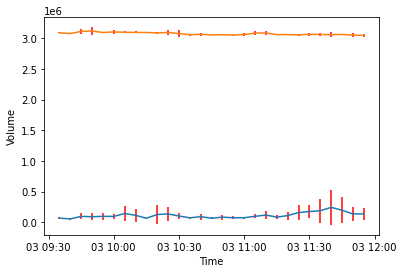

In [12]:
plt.xlabel('Time')
plt.ylabel('Volume')
plt.errorbar(temp[1:].EventTime, temp[1:].slave_vol['mean'], yerr=temp[1:].slave_vol['std'], ecolor='red')  
plt.errorbar(temp[1:].EventTime, temp[1:].tot_vol['mean'], yerr=temp[1:].tot_vol['std'], ecolor='red')  
plt.show()

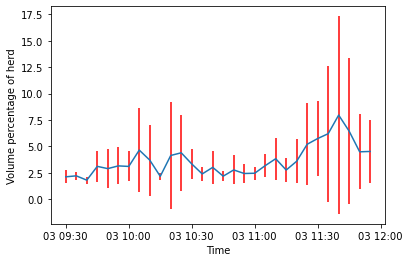

In [13]:
plt.xlabel('Time')
plt.ylabel('Volume percentage of herd')
plt.errorbar(temp.EventTime, temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [5]:
# Herd03 config

PATHS = []
for file in os.listdir('log'):
    if 'herd03' in file:
        PATHS.append(f'log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,286883.0,1234.0,6800,log/herd03_seed_422396446,0.181471
1,342187.0,8186.0,7072,log/herd03_seed_3842306364,1.157523
2,428872.0,5448.0,5555,log/herd03_seed_1345499493,0.980738
3,850660.0,3344.0,7072,log/herd03_seed_3842306364,0.472851
4,1003303.0,9093.0,9971,log/herd03_seed_602957303,0.911945
...,...,...,...,...,...
5995,998611239.0,1695.0,6065,log/herd03_seed_2876537340,0.279472
5996,998738060.0,5361.0,7940,log/herd03_seed_1923688040,0.675189
5997,998973671.0,2626.0,4764,log/herd03_seed_1261063143,0.551217
5998,999444814.0,8783.0,6512,log/herd03_seed_1768615473,1.348741


In [7]:
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT,g
0,286883.0,1234.0,6800,log/herd03_seed_422396446,0.181471,0
1,342187.0,8186.0,7072,log/herd03_seed_3842306364,1.157523,0
2,428872.0,5448.0,5555,log/herd03_seed_1345499493,0.980738,0
3,850660.0,3344.0,7072,log/herd03_seed_3842306364,0.472851,0
4,1003303.0,9093.0,9971,log/herd03_seed_602957303,0.911945,0
...,...,...,...,...,...,...
5995,998611239.0,1695.0,6065,log/herd03_seed_2876537340,0.279472,19
5996,998738060.0,5361.0,7940,log/herd03_seed_1923688040,0.675189,19
5997,998973671.0,2626.0,4764,log/herd03_seed_1261063143,0.551217,19
5998,999444814.0,8783.0,6512,log/herd03_seed_1768615473,1.348741,19


In [8]:
df['g'] = df.index//300
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY               SLAVE_PROFIT              MASTER_PROFIT  \
            mean           std         mean          std          mean   
g                                                                        
0   2.599193e+07  1.497188e+07  9457.496667  5778.447932   9390.543333   
1   7.482449e+07  1.418810e+07  8971.156667  4933.225749   8969.966667   
2   1.237401e+08  1.472173e+07  8680.096667  4941.580985   8983.770000   
3   1.765181e+08  1.430960e+07  8897.710000  5517.329115   9313.080000   
4   2.239471e+08  1.459970e+07  8916.420000  4986.964285   9494.933333   
5   2.772314e+08  1.485603e+07  8849.510000  4914.496772   9679.826667   
6   3.308337e+08  1.567792e+07  8173.880000  4581.363629   9346.656667   
7   3.809213e+08  1.420441e+07  7806.470000  4648.578468   8911.983333   
8   4.282417e+08  1.397103e+07  8138.876667  5012.520901   9368.830000   
9   4.748018e+08  1.233859e+07  8366.826667  5644.717292   9406.496667   
10  5.237470e+08  1.624924e+07  7119.570000  4422.693576   8880.450000   
11  5.794474e+08  1.542855e+07  6802.776667  3617.596336   8823.633333   
12  6.296114e+08  1.369760e+07  6903.563333  4774.717785   8990.036667   
13  6.802370e+08  1.480414e+07  6822.043333  4241.086362   9053.670000   
14  7.294241e+08  1.261331e+07  6324.733333  3735.629622   8863.393333   
15  7.745879e+08  1.380868e+07  6529.426667  4623.596408   9019.036667   
16  8.258070e+08  1.542038e+07  6616.430000  4576.658562   9233.403333   
17  8.771747e+08  1.293181e+07  6988.800000  5137.023542   9323.496667   
18  9.256565e+08  1.473236e+07  6877.746667  4985.046206   9593.343333   
19  9.748717e+08  1.428819e+07  6740.380000  5537.769514   9986.850000   

                  PERCENT            
            std      mean       std  
g                                    
0   5341.543147  1.014528  0.324281  
1   4100.095029  0.999235  0.308430  
2   4682.379673  0.973812  0.329942  
3   5176.908698  0.955516  0.383197  
4   4969.716060  0.955494  0.321042  
5   4958.589690  0.924929  0.290633  
6   4907.671782  0.886583  0.311998  
7   4681.188495  0.892054  0.406446  
8   4752.195611  0.862762  0.299817  
9   4852.364519  0.897599  0.482215  
10  4143.496237  0.808658  0.368183  
11  3668.873450  0.772290  0.313708  
12  5010.610723  0.770382  0.384129  
13  4074.939808  0.740740  0.284066  
14  4159.098342  0.714143  0.303871  
15  4470.089540  0.717423  0.361516  
16  4571.399770  0.694278  0.317925  
17  4142.323165  0.729346  0.410760  
18  4574.674731  0.704226  0.408053  
19  6281.402821  0.663835  0.358614

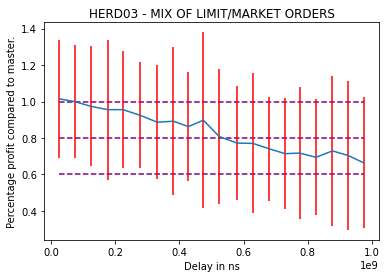

In [27]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
plt.title('HERD03 - MIX OF LIMIT/MARKET ORDERS')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.8, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [13]:
# Herd04 config

PATHS = []
for file in os.listdir('log'):
    if 'herd04' in file:
        PATHS.append(f'log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,286883.0,1618.0,7463,log/herd04_seed_422396446,0.216803
1,342187.0,8117.0,7959,log/herd04_seed_3842306364,1.019852
2,428872.0,5548.0,5672,log/herd04_seed_1345499493,0.978138
3,850660.0,5929.0,7959,log/herd04_seed_3842306364,0.744943
4,1003303.0,10293.0,10547,log/herd04_seed_602957303,0.975917
...,...,...,...,...,...
5995,998611239.0,1698.0,4981,log/herd04_seed_2876537340,0.340895
5996,998738060.0,5686.0,6857,log/herd04_seed_1923688040,0.829226
5997,998973671.0,9345.0,8345,log/herd04_seed_1261063143,1.119832
5998,999444814.0,13219.0,5419,log/herd04_seed_1768615473,2.439380


In [14]:
df['g'] = df.index//300
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY               SLAVE_PROFIT              MASTER_PROFIT  \
            mean           std         mean          std          mean   
g                                                                        
0   2.599193e+07  1.497188e+07  9225.273333  5546.062491   9132.676667   
1   7.482449e+07  1.418810e+07  8510.350000  4482.921686   8578.983333   
2   1.237401e+08  1.472173e+07  8601.390000  5149.134640   8710.060000   
3   1.765181e+08  1.430960e+07  9181.946667  6056.928642   9039.710000   
4   2.239471e+08  1.459970e+07  9043.823333  5916.640942   9080.283333   
5   2.772314e+08  1.485603e+07  9259.386667  5865.666299   9367.860000   
6   3.308337e+08  1.567792e+07  8614.353333  5474.913255   8916.856667   
7   3.809213e+08  1.420441e+07  8906.850000  6737.910613   8679.253333   
8   4.282417e+08  1.397103e+07  9684.103333  7038.048660   9151.576667   
9   4.748018e+08  1.233859e+07  8989.736667  6339.889451   8918.936667   
10  5.237470e+08  1.624924e+07  8118.053333  5544.413230   8516.616667   
11  5.794474e+08  1.542855e+07  8265.410000  5311.062595   8583.626667   
12  6.296114e+08  1.369760e+07  8425.623333  6223.261916   8617.473333   
13  6.802370e+08  1.480414e+07  8087.576667  4865.851556   8625.180000   
14  7.294241e+08  1.261331e+07  8297.576667  5595.637216   8704.853333   
15  7.745879e+08  1.380868e+07  8286.036667  5434.570692   8700.926667   
16  8.258070e+08  1.542038e+07  8375.730000  6128.606646   8925.973333   
17  8.771747e+08  1.293181e+07  9108.140000  6178.277684   8917.400000   
18  9.256565e+08  1.473236e+07  8937.450000  7472.431445   9134.293333   
19  9.748717e+08  1.428819e+07  8631.570000  6653.075279   9516.860000   

                  PERCENT            
            std      mean       std  
g                                    
0   5053.850992  1.015329  0.322493  
1   4050.085285  0.992320  0.268130  
2   4515.663388  0.981005  0.316073  
3   4969.031826  0.999101  0.400415  
4   4852.283068  0.983403  0.353306  
5   4779.487356  0.985976  0.390688  
6   4707.835285  0.964605  0.387759  
7   4526.414146  1.014091  0.528746  
8   4662.449865  1.039920  0.509493  
9   4664.160633  0.999510  0.529656  
10  4029.286768  0.957364  0.463166  
11  3788.132458  0.954960  0.435337  
12  4741.219168  0.957953  0.470098  
13  3992.945346  0.942973  0.400581  
14  4128.536741  0.946961  0.427590  
15  4423.395741  0.963756  0.470902  
16  4532.323475  0.923259  0.461986  
17  4034.185601  1.030683  0.564829  
18  4449.804684  0.952537  0.562920  
19  5897.470108  0.918803  0.510648

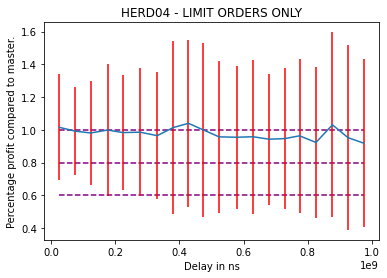

In [15]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
plt.title('HERD04 - LIMIT ORDERS ONLY')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.8, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [27]:
df[df.DELAY > 500000000]

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT,g
3026,500045550.0,8829.0,8123,log/herd04_seed_4033523166,1.086914,10
3027,500117076.0,7414.0,7595,log/herd04_seed_4018109721,0.976169,10
3028,500331823.0,3009.0,4623,log/herd04_seed_878115723,0.650876,10
3029,500496168.0,5130.0,6644,log/herd04_seed_78547565,0.772125,10
3030,500672920.0,10749.0,13575,log/herd04_seed_2289927481,0.791823,10
...,...,...,...,...,...,...
5995,998611239.0,1698.0,4981,log/herd04_seed_2876537340,0.340895,19
5996,998738060.0,5686.0,6857,log/herd04_seed_1923688040,0.829226,19
5997,998973671.0,9345.0,8345,log/herd04_seed_1261063143,1.119832,19
5998,999444814.0,13219.0,5419,log/herd04_seed_1768615473,2.439380,19


In [26]:
df[df.DELAY > 500000000].agg(['mean', 'std'])

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,PERCENT,g
mean,7.542805e+08,8458.648621,8820.151648,0.955613,14.539341
std,1.421994e+08,5996.378361,4442.557090,0.480919,2.854169


In [35]:
# Herd05 config

PATHS = []
for file in os.listdir('log'):
    if 'herd05' in file:
        PATHS.append(f'log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,342187.0,9624.0,8717,log/herd05_seed_3842306364,1.104050
1,428872.0,5725.0,5891,log/herd05_seed_1345499493,0.971821
2,850660.0,4929.0,8717,log/herd05_seed_3842306364,0.565447
3,1003303.0,10742.0,11153,log/herd05_seed_602957303,0.963149
4,1003317.0,6627.0,6422,log/herd05_seed_1703301249,1.031922
...,...,...,...,...,...
4075,998536725.0,5118.0,7251,log/herd05_seed_799981516,0.705834
4076,998607901.0,3089.0,6260,log/herd05_seed_491263,0.493450
4077,998611239.0,1114.0,5245,log/herd05_seed_2876537340,0.212393
4078,999444814.0,3021.0,5802,log/herd05_seed_1768615473,0.520683


In [37]:
df['g'] = df.index//200
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY               SLAVE_PROFIT              MASTER_PROFIT  \
            mean           std         mean          std          mean   
g                                                                        
0   2.569856e+07  1.494620e+07    10139.830  4769.982777    10187.6150   
1   7.602921e+07  1.375053e+07     9611.775  4246.720116     9683.7100   
2   1.215447e+08  1.414372e+07     9194.160  4077.812685     9905.1750   
3   1.739338e+08  1.465867e+07     9614.025  4441.180458    10077.8650   
4   2.206514e+08  1.404237e+07     8852.775  3942.392558     9961.2350   
5   2.716064e+08  1.461271e+07     8979.555  4005.246214    10481.7100   
6   3.247380e+08  1.568232e+07     7851.990  3584.614450     9788.5050   
7   3.738488e+08  1.306477e+07     7852.875  3835.956846     9697.1300   
8   4.206288e+08  1.331565e+07     8188.795  3535.921135    10386.8900   
9   4.689103e+08  1.301438e+07     8082.800  4284.463320    10264.8150   
10  5.176126e+08  1.654254e+07     7198.760  3506.889147     9973.7150   
11  5.735435e+08  1.584492e+07     6952.780  3660.188476     9770.4250   
12  6.207850e+08  1.273668e+07     6578.265  3454.177348     9750.7000   
13  6.686864e+08  1.505214e+07     6782.920  4066.815235     9871.2550   
14  7.163412e+08  1.396388e+07     6300.755  3611.754234     9899.9250   
15  7.618015e+08  1.284436e+07     6282.090  3624.041764     9779.8850   
16  8.088643e+08  1.420849e+07     6148.135  3829.190046     9997.2100   
17  8.590129e+08  1.426947e+07     6660.280  4196.977375    10158.0700   
18  9.048704e+08  1.427715e+07     6424.135  4004.323526    10373.2150   
19  9.560730e+08  1.474281e+07     5690.915  3665.985374     9972.3850   
20  9.900653e+08  5.846571e+06     5070.750  3723.553215     9591.1625   

                  PERCENT            
            std      mean       std  
g                                    
0   3913.324669  0.991478  0.256033  
1   3551.166060  0.985136  0.203284  
2   3745.965985  0.927235  0.180516  
3   3613.435679  0.947335  0.296032  
4   3729.454144  0.886312  0.197195  
5   3874.834494  0.852055  0.187736  
6   3821.050887  0.799573  0.179251  
7   3698.457733  0.810101  0.255147  
8   3700.558483  0.792279  0.216915  
9   3732.702088  0.772266  0.279653  
10  3705.896375  0.715948  0.199948  
11  3760.605935  0.698516  0.230826  
12  3692.569755  0.665885  0.226792  
13  3929.557916  0.659890  0.232228  
14  3686.117070  0.618270  0.213583  
15  3608.674198  0.622330  0.225647  
16  3854.490535  0.583821  0.223455  
17  3978.700958  0.622195  0.234540  
18  3771.805590  0.593514  0.244210  
19  3576.311058  0.542806  0.244625  
20  3602.697451  0.496248  0.246462

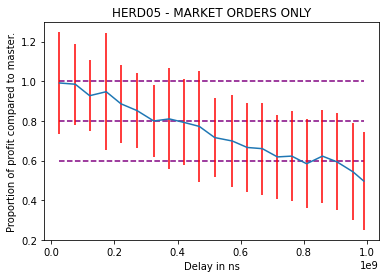

In [38]:
plt.xlabel('Delay in ns')
plt.ylabel('Proportion of profit compared to master.')
plt.title('HERD05 - MARKET ORDERS ONLY')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.8, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()